<a href="https://colab.research.google.com/github/joaochenriques/MCTE_2022/blob/main/ChannelFlows/HystogramsPowerProduction/EnergyProduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mpl

In [29]:
import pathlib
if not pathlib.Path("mpl_utils.py").exists():
  !curl -O https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/libs/mpl_utils.py &> /dev/null

import mpl_utils as mut
mut.config_plots()

%config InlineBackend.figure_formats = ['svg']

In [30]:
import sys, pathlib
if 'google.colab' in sys.modules and not pathlib.Path("Data.xlsx").exists():
  !curl -O https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/ChannelFlows/HystogramsPowerProduction/Data.xlsx &> /dev/null

## Energy produced

Energy produced during time $T$ for a single unit 
$$E(T) = \int_0^T P_u(t) dt$$
where $P_u$ is instantaneous power 

The energy produce during one year $T=8760\,$h is the energy yield of the unit.

The unit power is given by
$$P_u(t) = \eta_T P(T)$$
where

* $\eta_T$: total efficiency of the power train and electrical generator
* $\displaystyle P(t) = \frac{1}{2} \rho U(t)^3 A \, C_p(t)$: instantaneous power at turbine shaft
* $C_p(t)$: is the instantaneous power coefficient 
* $U(t)$: instantaneous stream velocity
* $\rho$: water density 
* $A$: capture area

## Capacity factor

If the unit operates at the rated power $P_\text{rated}$ during time $T$ the energy produced is 
$$E_\text{rated} = P_\text{rated} T$$

The capacity factor is defined as annual energy yield over the energy yield at 100% rated power
$$\frac{E}{E_\text{rated}} = \frac{1}{T} \int_0^{T} \frac{P_u(t)}{P_\text{rated}} dt $$

In **general** the instantaneous power is less than the rated power 
$$P(t) < P_\text{rated}$$
and the capacity factor is less than 1


The **annual energy yield** = number of hours/year $\times$ installed power $\times$ capacity factor

e.g. 
$$E = 8760\text{h}\times 10\text{MW} \times 0.35\approx 30\text{GWh/y}$$  

## Computing the annual energy yield

If we know
* $P_{u}(U)$ - the Turbine Power Curve as function of velocity 
* $f(U)$ - the frequency distribution of Current Speed classes 


then the energy produce is computed from
$$
E=\int_{U_\text{cut-in}}^{U_\text{cut-out}} P_u(U) f(U) d U \cong \sum P_{u}(U) f(U) \Delta U
$$
where
* $U_\text{cut-in}$: Turbine cut-in speed
* $U_\text{cut-out}$: Turbine cut-out speed

## Maximum energy production vs real

Theoretical conditions for maximum energy production

<img src="https://github.com/joaochenriques/MCTE_2020_2021/blob/main/HistogramsForEnergyProduction/figs/PowerCurve_cin_cout.svg?raw=1" width="300px" style="display:inline">

**'Ideal turbine'**
- $U_\text{cut-in}=0$
- $U_\text{cut-out}=\infty$
- always $C_{P,\text{max}}$ 

**Real Turbine**
- $U_\text{cut-in}>0$
- $U_\text{cut-out}$ finite
- Close to $C_{P,\text{max}}$ until $U_\text{rated}$
- $P=P_\text{rated}$  for  $\mathrm{U}>U_\text{rated}$
- $P=0$  for  $U>U_\text{cut-out}$
- Typical values: 
  - $C_{P,\text{max}} \approx 0.35-0.50$
  - $\eta_{\text{drivetrain}} \approx 0.92-0.95$

## The annual energy yield considering the turbine curve 

If the Turbine Power Curve is known as function of velocity: $P_{U}(U)$
If the Current Speed is known as function of time:
$$
E=\int_{0}^\text{1 year} P_{u}(U(t)) d t \approx \sum P_{u}(U(t)) \Delta t
$$
where
$$
\begin{array}{ll}
P_{u}(U)=0 & \text { if } U(t)<U_{\text{cut-in}} \\
P_{u}(U)= C_{P} \, \frac{1}{2} \rho U(t)^{3} A & \text { if } U_{\text{cut-in}}<U(t)<U_{\text {rated }} \\
P_{u}(U)=P_{\text {rated }} & \text { if } U_{\text {rated }}<U(t)<U_{\text{cut-out }} \\
P_{u}(U)=0 & \text { if } U_{\text {cut-out }}<U(t)
\end{array}
$$
$\Delta t$ May be taken at $1 \mathrm{~h}$

## Annual energy yield based on histograms

<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/ChannelFlows/HystogramsPowerProduction/figs/AnnualEnergy.svg?raw=1" width="600px" style="display:inline">


## Create an histogram

We start by reading an excel file with a time series of velocities at a given location

In [31]:
df = pd.read_excel( 'Data.xlsx', "Sheet1")
list(df.keys())

['hrs', 'days', 'U', 'abs_U', 'U^3']

Assign excel columns to vectors

In [32]:
hrs = np.array( df['hrs'])
U = np.array( df['U'])
abs_U = np.array( df['abs_U'])
U3 = np.array( df['U^3'])

Plot an interval of the time series 

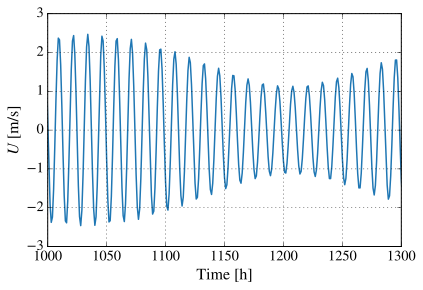

In [33]:
fig = mpl.figure(figsize=(6,4))
mpl.plot( hrs, U, '-' )
mpl.grid()
mpl.xlabel('Time [h]')
mpl.ylabel('$U$ [m/s]')
mpl.xlim( 1000,1300 );

Plot the time series of absolute value of the velocity (note that there is no zero crossing) 

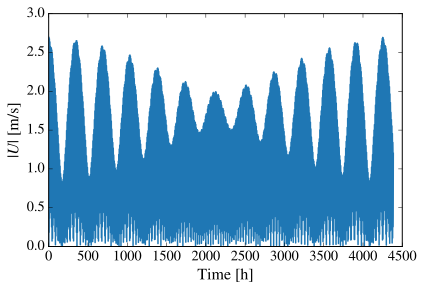

In [34]:
mpl.figure(figsize=(6,4))
mpl.plot( hrs, abs_U )
mpl.xlabel('Time [h]')
mpl.ylabel('$|U|$ [m/s]');

Let us compute the number of bins. 

In [35]:
U_bin_size = 0.2
U_max = np.max( abs_U )
U_max_bins = int( U_max / U_bin_size )+1
U_max, U_max_bins

(2.695408127824624, 14)

Compute the number of hours in each bin

In [36]:
U_bins_cnt = np.zeros( U_max_bins )

for u in abs_U:
  n = int( u / U_bin_size )
  U_bins_cnt[n] += 1

Define the labels of the x-axis for plotting

In [37]:
U_bins_cls = np.linspace( 0.0, (U_max_bins-1)*U_bin_size, U_max_bins )
U_bins_cls += U_bin_size*0.5
U_bins_id = [ ( "%.1f" % n) for n in U_bins_cls ]

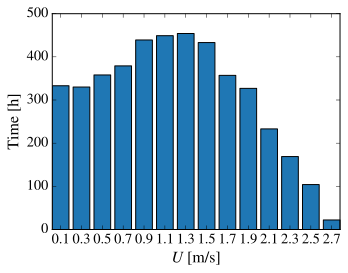

In [38]:
fig = mpl.figure(figsize=(4,3))
ax = fig.add_axes([0,0,1,1])
ax.bar(U_bins_id,U_bins_cnt,width=0.8)
mpl.xlabel('$U$ [m/s]')
mpl.ylabel('Time [h]')
mpl.ylim( 0, 500 );

In [39]:
U3_bin_size = 1
U3_max = np.max( U3 )
U3_max_bins = int( U3_max / U3_bin_size )+1

In [40]:
U3_bins_cnt = np.zeros( U3_max_bins )

for u3 in U3:
  n = int( u3 / U3_bin_size )
  U3_bins_cnt[n] += 1

In [41]:
U3_bins_cls = np.linspace( 0.0, (U3_max_bins-1)*U3_bin_size, U3_max_bins )
U3_bins_cls += 0.5
U3_bins_id = [ ( "%.1f" % n) for n in U3_bins_cls ]

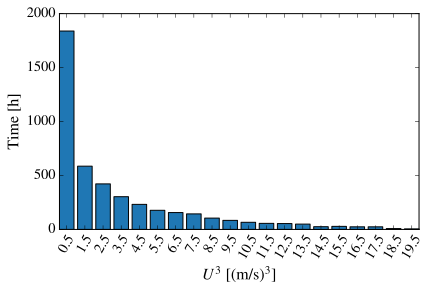

In [42]:
fig = mpl.figure(figsize=(5,3))
ax = fig.add_axes([0,0,1,1])
ax.bar(U3_bins_id,U3_bins_cnt,width=0.8)
mpl.xlabel('$U^3$ [(m/s)$^3$]')
mpl.ylabel('Time [h]')
mpl.ylim( 0, 2000 );
mpl.xticks(U3_bins_id,U3_bins_cls,rotation=60);

Simulation data for a turbine rotor radius of 4.0m and a rated power of 120kW

In [43]:
At = np.pi*4.0**2
Prated = 50E3

CP = 0.48 # at optimal TSR (best efficiency point)
rho_w = 1000

Cut-in values

In [44]:
U_cut_in = 0.4
P_cut_in = 0.5*rho_w*U_cut_in**3*At * CP

Compute the turbine curve 

In [45]:
Ucur = U_bins_cls

Pwr = 0.5 * rho_w * Ucur**3 * At * CP
Pwr_kW = Pwr / 1000.0
Pwr_lim = np.where( Pwr <= P_cut_in, 0.0, np.where( Pwr <= Prated, Pwr, Prated ) )
Pwr_lim_kW = Pwr_lim / 1000.0

Plot the ideal and the 'real' curve

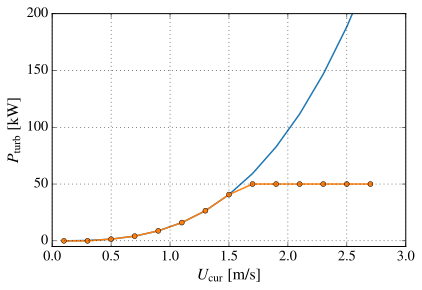

In [46]:
mpl.figure(figsize=(6,4))
mpl.plot( Ucur, Pwr_kW, '-' )
mpl.plot( Ucur, Pwr_lim_kW, 'o-' )
mpl.xlabel('$U_\mathrm{cur}$ [m/s]')
mpl.ylabel('$P_\mathrm{turb}$ [kW]' )
mpl.ylim( -5,200 )
mpl.grid()

Plot the impose $C_P$ curve

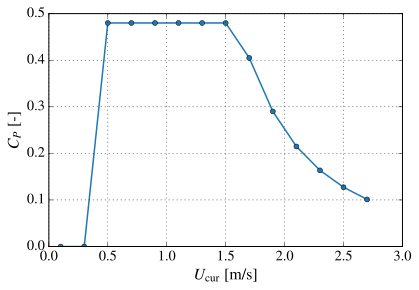

In [47]:
Pwr[0] = 1E-6 # avoid division by zero
CP_lim = ( Pwr_lim / Pwr ) * CP 
mpl.figure(figsize=(6,4))
mpl.plot( Ucur,  CP_lim, 'o-' )
mpl.xlabel('$U_\mathrm{cur}$ [m/s]')
mpl.ylabel('$C_P$ [-]' )
mpl.ylim( 0, 0.50 )
mpl.grid()

create pretty table just for displaying

In [48]:
dfdic = { "Ucur [m/s]":Ucur, "bins [h]":U_bins_cnt, "PowerCurve[kW]":Pwr_lim_kW }
df = pd.DataFrame( dfdic )
df

,Ucur [m/s],bins [h],PowerCurve[kW]
0,0.1,333.0,0.000000
1,0.3,330.0,0.000000
2,0.5,358.0,1.507964
3,0.7,379.0,4.137855
4,0.9,439.0,8.794449
5,1.1,449.0,16.056806
6,1.3,454.0,26.503984
7,1.5,433.0,40.715041
8,1.7,357.0,50.000000
9,1.9,327.0,50.000000


Annual Power production is the dot product of two columns above

In [49]:
Annual_Power = np.dot( U_bins_cnt, Pwr_lim_kW )
print( "Annual Power production = %.1fkWh" % Annual_Power )

Annual Power production = 103440.8kWh


## Power density

<img src="https://github.com/joaochenriques/MCTE_2020_2021/blob/main/HistogramsForEnergyProduction/figs/PowerDensity.svg?raw=1" width="600px" style="display:inline">

## Turbine matching

<img src="https://github.com/joaochenriques/MCTE_2020_2021/blob/main/HistogramsForEnergyProduction/figs/TurbineMatching.svg?raw=1" width="500px" style="display:inline">

## The Thrust

Comparing Tidal to Wind:

For the same power and the same operational conditions
* $P_{\text{wind}}=P_{\text{tidal}}$
* $C_{T_{\text{wind}}}=C_{T_{\text{tidal}}}$
* $C_{P_{\text{wind}}}=C_{P_{\text{tidal}}}$

we get

$\quad\displaystyle \frac{C_{T_\text{tidal}}}{C_{P_\text{tidal}}}=\frac{C_{T_\text{wind}}}{C_{P_\text{wind}}}$

giving after simplification

$\quad T_{\text{tidal}} U_{\text{tidal}} = T_{\text{wind}} U_{\text{wind}}$

Due to wind/tidal speed ratio

$\quad\displaystyle\frac{T_{\text{tidal}}}{T_{\text{wind}}}=\frac{U_{\text{wind}}}{U_{\text{tidal}}} \approx 4\text{ to }8$

**Need to include maximum thrust in design considerations**